In [1]:
import ross as rs
import numpy as np
import math
from scipy.optimize import least_squares 
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import pickle
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#--------------------------------------- define "real" rotor and simulated rotor----------------------------------------
steel = rs.Material(name="Steel", rho=7810, E=211e9, G_s=81.2e9)

n = 2

shaft_elem = [
    rs.ShaftElement(
        L=0.25,
        idl=0.0,
        odl=0.05,
        material=steel,
        shear_effects=True,
        rotary_inertia=True,
        gyroscopic = True
    )
    for _ in range(n)
]

disk0 = rs.DiskElement.from_geometry(
    n=1, material=steel, width=0.07, i_d=0.05, o_d=0.28
)

disks = [disk0]

stfx_real = 1e6
stfy_real = 0.8e6
dampx_real = 3e3
dampy_real = 3e3
bearing0_real = rs.BearingElement(0, kxx=stfx_real, kyy=stfy_real, cxx = dampx_real, cyy = dampy_real)
bearing1_real = rs.BearingElement(2, kxx=stfx_real, kyy=stfy_real, cxx = dampx_real, cyy = dampy_real)

bearings_real = [bearing0_real, bearing1_real]

rotor_real = rs.Rotor(shaft_elem, disks, bearings_real)

stfx_sim = 1e6
stfy_sim = 0.8e6
bearing0_sim = rs.BearingElement(0, kxx=stfx_sim, kyy=stfy_sim, cxx = 0, cyy = 0)
bearing1_sim = rs.BearingElement(2, kxx=stfx_sim, kyy=stfy_sim, cxx = 0, cyy = 0)

bearings_sim = [bearing0_sim, bearing1_sim]

rotor_sim = rs.Rotor(shaft_elem, disks, bearings_sim)

# plotting rotor model

fig_rotor_real = rotor_real.plot_rotor()
# fig_rotor_real.write_image("rotor_real.png")

In [3]:
#---------------------------------------- important variables-----------------------------------------------------------
SAMPLES = 61
FREQUENCY_RANGE = np.linspace(315, 1150, SAMPLES)
DISK_NODE = 1
SIGMA_TRUE = 0.01 
IMBALANCE_MAGNITUDE = 0.03
IMBALANCE_PHASE = 0

In [4]:
#-------------------------------------------return imbalance frequency response-----------------------------------------
def getImbalanceResponse(rotor_model, obs_node, magnitude, phase, frequency_range):
    '''
    rotor_model: the rotor object defined using ROSS library
    obs_node: node at which imbalance force is to be applied
    magnitude: magnitude of imbalance
    phase: phase of imbalance (Radians)
    frequency_range: range of frequencies which are being considered
    return:
        results: a results object
        fr: a matrix of the magnitudes and phases in the x and y directions
    '''
    probex = (1, 0)
    probey = (1, 90)

    results = rotor_model.run_unbalance_response(obs_node, magnitude, phase, frequency_range)
    x_mag = results.data_magnitude(probe=[probex], probe_units="degrees").loc[:, 'Probe 1 - Node 1'].values
    x_phase = results.data_phase(probe=[probex], probe_units="degrees").loc[:, 'Probe 1 - Node 1'].values
    y_mag = results.data_magnitude(probe=[probey], probe_units="degrees").loc[:, 'Probe 1 - Node 1'].values
    y_phase = results.data_phase(probe=[probey], probe_units="degrees").loc[:, 'Probe 1 - Node 1'].values
    fr = np.vstack((x_mag, x_phase, y_mag, y_phase))

    return results, fr

In [5]:
#---------------------------------------- real imbalance response-------------------------------------------------------
samples = 61
results_real, fr_real = getImbalanceResponse(rotor_real, DISK_NODE, IMBALANCE_MAGNITUDE, IMBALANCE_PHASE, FREQUENCY_RANGE)

# noise
epsilon = np.random.randn(4, SAMPLES) * SIGMA_TRUE
observations = fr_real + epsilon

# plot real response
probe_real = (1, 45)
fig_results_real = results_real.plot(probe = [probe_real], probe_units="degrees")
fig_results_real.write_image("fr_real.png")

In [6]:
#-------------------------------------- simulated imbalance response----------------------------------------------------
results_sim, fr_sim = getImbalanceResponse(rotor_sim, DISK_NODE, IMBALANCE_MAGNITUDE, IMBALANCE_PHASE, FREQUENCY_RANGE)

# plot sim response
probe_sim = (1, 45)
fig_results_sim = results_sim.plot(probe = [probe_sim], probe_units="degrees")
fig_results_sim.write_image("fr_sim.png")

In [7]:
#-------------------------------------- least-squares formulation-------------------------------------------------------


In [8]:
#-----------------------------------------theano op for rotor model-----------------------------------------------------
class RotorModelOp(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dmatrix]  # outputs a single scalar value (the log likelihood)

    def __init__(self, get_imb_resp,rotor_model, obs_node, frequency_range):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        """
        # add inputs as class attributes
        self.get_imb_resp = get_imb_resp
        self.rotor_model = rotor_model
        self.obs_node = obs_node
        self.frequency_range = frequency_range

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (Beta,) = inputs  # this will contain my variables

        mag = Beta[0]
        ph = Beta[1]

        # call the log-likelihood function
        _, outputs[0][0] = getImbalanceResponse(self.rotor_model, self.obs_node, mag, ph, self.frequency_range)

In [9]:
# #------------------------- model config: no discrepancy-----------------------------------------------------------
# imb_resp_op = RotorModelOp(get_imb_resp=getImbalanceResponse, rotor_model=rotor_sim, obs_node=DISK_NODE, frequency_range=FREQUENCY_RANGE)
# rotor_model = pm.Model()

# with rotor_model:
#     # Priors for unknown model parameters
#     mag_rand = pm.HalfNormal('mag_rand', sigma=0.4) # magnitude is always positive
#     phase_rand = pm.Uniform('phase_rand', lower = 0, upper = 2*math.pi ) # radians

#     Beta = tt.as_tensor_variable([mag_rand, phase_rand])

#     mu = imb_resp_op(Beta)

#     # Likelihood (sampling distribution) of observations
#     Y_obs = pm.Normal("Y_obs", mu=mu, sigma=SIGMA_TRUE, observed=observations)


    


In [10]:
#------------------------------------------model config: with discrepancy-----------------------------------------
# create op
imb_resp_op = RotorModelOp(get_imb_resp=getImbalanceResponse, rotor_model=rotor_sim, obs_node=DISK_NODE, frequency_range=FREQUENCY_RANGE)
rotor_model = pm.Model()

X = FREQUENCY_RANGE.reshape((-1,1))

with rotor_model:
    # gaussian process hyper-parameters
    length_scale = pm.Bound(pm.Gamma, upper = 4)("length_scale", alpha=5, beta=5) # taken from discrepancy modeling paper
    eta = pm.HalfCauchy('eta', beta=5)

    # define covariance matrix
    cov_func = (eta**2) * pm.gp.cov.ExpQuad(1, ls=length_scale)
    Sigma = cov_func(X) + np.eye(SAMPLES)*SIGMA_TRUE**2 # gaussian process covariance + noise covariance

    # Priors for unknown model parameters
    mag_rand = pm.HalfNormal('mag_rand', sigma=0.05) # magnitude is always positive
    phase_rand = pm.Uniform('phase_rand', lower = 0, upper = 2*math.pi ) # radians

    Beta = tt.as_tensor_variable([mag_rand, phase_rand])
    
    # mean (gaussian process is zero mean)
    mu = imb_resp_op(Beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.MvNormal("Y_obs", mu=mu, cov=Sigma, observed=observations)




In [11]:
#--------------------------------------------sample-----------------------------------------------------------------
with rotor_model:
    step = pm.Metropolis()
    # no discrepancy
    # trace = pm.sample(6000, step = step, tune = 3000, chains = 2, return_inferencedata=False, cores=1)
    # discrepancy
    trace = pm.sample(1,tune = 1, step = step, return_inferencedata=True)


Only 1 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [phase_rand]
>Metropolis: [mag_rand]
>Metropolis: [eta]
>Metropolis: [length_scale]


Sampling 4 chains for 1 tune and 1 draw iterations (4 + 4 draws total) took 20 seconds.
/home/rahul/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/data/base.py:169: UserWarning:

More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)

/home/rahul/anaconda3/envs/pymc_env/lib/python3.10/site-packages/pymc3/sampling.py:643: UserWarning:

The number of samples is too small to check convergence reliably.



In [12]:
#---------------------------------------------save trace------------------------------------------------------------
experiment = "test1"
with rotor_model:
    print('saving trace')
    #pickle.dump(trace, open( "trace_discrepancy.p", "wb" ) )
    trace.to_netcdf("trace_"+experiment+".nc")

saving trace


'trace_test1.nc'

loading trace


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

arviz - WARNING - Shape validation failed: input_shape: (4, 1), minimum_shape: (chains=1, draws=4)


summarizing trace
              mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
length_scale  2.39  0.78    1.48     3.39        NaN      NaN       NaN   
eta           4.79  0.41    4.17     5.00        NaN      NaN       NaN   
mag_rand      0.06  0.05    0.02     0.13        NaN      NaN       NaN   
phase_rand    2.78  2.21    0.50     4.72        NaN      NaN       NaN   

              ess_tail  r_hat  
length_scale       NaN    NaN  
eta                NaN    NaN  
mag_rand           NaN    NaN  
phase_rand         NaN    NaN  
plotting trace


/home/rahul/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/density_utils.py:606: UserWarning:

Something failed: `x` is of length 1. Can't produce a KDE with only one data point.

/home/rahul/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/density_utils.py:606: UserWarning:

Something failed: `x` is of length 1. Can't produce a KDE with only one data point.

/home/rahul/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/density_utils.py:606: UserWarning:

Something failed: `x` is of length 1. Can't produce a KDE with only one data point.

/home/rahul/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/density_utils.py:606: UserWarning:

Something failed: `x` is of length 1. Can't produce a KDE with only one data point.

/home/rahul/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:420: UserWarning:

Attempting to set identical left == right == <xarray.DataArray 'draw' ()>
array

array([[<AxesSubplot:title={'center':'length_scale'}>,
        <AxesSubplot:title={'center':'length_scale'}>],
       [<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'mag_rand'}>,
        <AxesSubplot:title={'center':'mag_rand'}>],
       [<AxesSubplot:title={'center':'phase_rand'}>,
        <AxesSubplot:title={'center':'phase_rand'}>]], dtype=object)

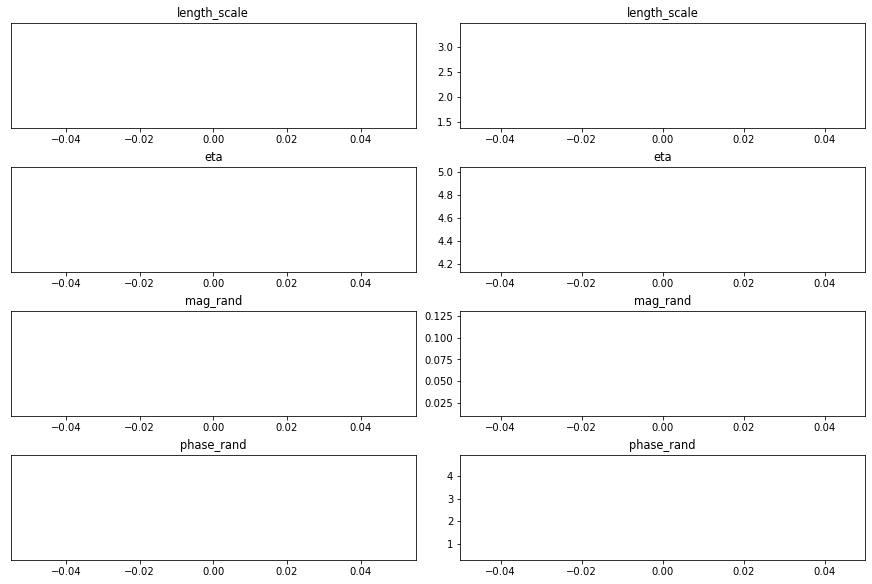

In [13]:
#------------------------------------ load trace and post process---------------------------------------------------
experiment = "test1"
with rotor_model:    
    print('loading trace')
    #trace = pickle.load(open("trace_discrepancy.p", "rb"))
    az.from_netcdf("trace_"+experiment+".nc")
    print('summarizing trace')
    print(az.summary(trace, round_to=2))
    print('plotting trace')
    az.plot_trace(trace)


In [14]:
# # Bayesian formulation with discrepancy (second) method

# # solve with bayesian inference, model discrepancy included
# X = FREQUENCY_RANGE.reshape((-1,1))

# discrepancy_gp_model = pm.Model()
# class Blackbox_Model(pm.gp.mean.Mean):
#     def __init__(self, Beta, rotor_model=rotor_sim, obs_node=DISK_NODE):
#         self.Beta = Beta
#         self.rotor_model = rotor_model
#         self.obs_node = DISK_NODE
        

#     def __call__(self, x):
#         # return simulator prediction given theta and X
#         x = x.reshape((-1,))
#         imb_resp_op = RotorModelOp(get_imb_resp=getImbalanceResponse, rotor_model=self.rotor_model, obs_node=self.obs_node, frequency_range=x)
#         return imb_resp_op(Beta)

# print('done')

# with discrepancy_gp_model:
#     # priors on parameters
#     # half-normal distribution may be biasing it to be larger
#     # Priors for unknown model parameters
#     mag_rand = pm.HalfNormal('mag_rand', sigma=0.4) # magnitude is always positive
#     phase_rand = pm.Uniform('phase_rand', lower = 0, upper = 2*math.pi ) # radians

#     Beta = tt.as_tensor_variable([mag_rand, phase_rand])
    
#     # priors for GP covariance
#     length_scale = pm.Bound(pm.Gamma, upper = 4)("length_scale", alpha=5, beta=5) # taken from discrepancy modeling paper
#     eta = pm.HalfCauchy('eta', beta=5)

#     # prior on discrepancy function (zero mean)
#     mean_func = Blackbox_Model(Beta)
#     cov_func = (eta**2) * pm.gp.cov.ExpQuad(1, ls=length_scale)
#     gp = pm.gp.Marginal(mean_func= mean_func, cov_func = cov_func)

#     # discrepancy = gp.prior("discrepancy", X = X)
#     y_ = gp.marginal_likelihood("y", X=X, y=observations, noise = SIGMA_TRUE)

#     # run inference
#     step = pm.Metropolis()
#     #trace = pm.sample(10, tune = 40, step = step, chains = 2, return_inferencedata=True)
#     trace = pm.sample(1000, tune = 4000, step = step, chains = 2, return_inferencedata=True)
    
#     #print(az.summary(trace, round_to=2))

#     plt.show()